In [1]:
import cdpm
from cdpm import CondDirichletProcessMix
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from bayesiankalman import mcmc
from tqdm import tqdm
import pandas as pd
import seaborn.apionly as sns
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from matplotlib import cm, pyplot as pltf
from sklearn.preprocessing import add_dummy_feature

In [2]:
%matplotlib inline
plt.style.use(['seaborn-dark-palette', 'seaborn-poster'])

In [3]:
time_dim = 500
num_draws = 20000
stick_scale = 1
beta_mu, beta_sigma = np.atleast_2d([0]), np.array([.05]) # mean and standard deviation
precn_df, precn_scale = 100, 1

In [4]:
mean_precn = np.asarray(precn_scale *precn_df)

In [5]:
np.random.seed(424)

In [6]:
# initial period
alpha_series = []
alpha_series.append(0.0)  # initial alpha value is 0.0

In [7]:
cl_idx = 0 
for time_idx in tqdm(range(time_dim)):
    omega_unif = np.random.uniform(0, 1)                                                                       
       
    if (omega_unif < 0.05):
        alpha = 1.0 + np.random.normal(0,np.sqrt(1/mean_precn),1)[0]
    elif (omega_unif >= 0.05 and omega_unif < 0.95):
        alpha = 0.9*alpha_series[time_idx] + np.random.normal(0,np.sqrt(1/mean_precn),1)[0]
    else:    
        alpha = -1.0 + np.random.normal(0,np.sqrt(1/mean_precn),1)[0]
    
    alpha_series.append(alpha)

100%|██████████| 500/500 [00:00<00:00, 52864.94it/s]


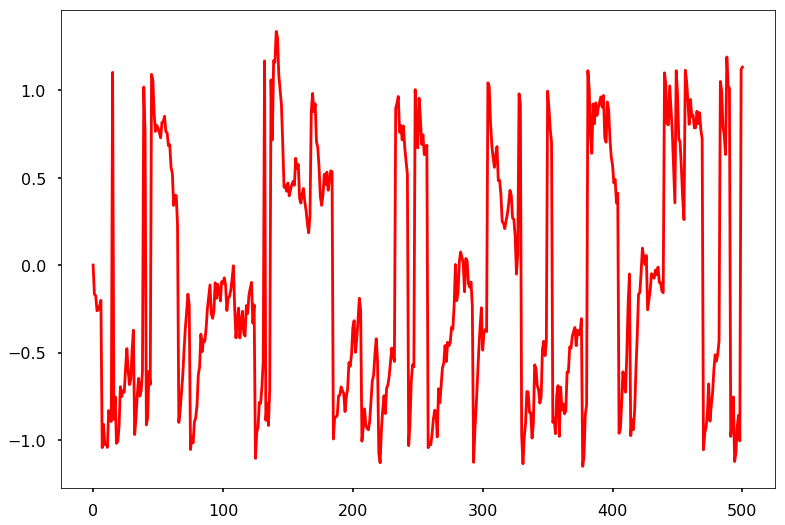

In [8]:
alpha_series_fig, alpha_series_ax = plt.subplots(1,1)
alpha_series_ax.plot(alpha_series, c='red')

## Estimation

In [9]:
prior = {
    'comp': {
        'coeff': {'mean': [beta_mu], 'cov': [beta_sigma]},
        'precn': {'scale': [precn_scale**(-1)], 'shape': [precn_df]}
    },
    'sticks': {
        'params': {
            'c': [stick_scale]
        }
    }
}

In [10]:
mean_precn = np.asarray(precn_scale / (precn_df - 1))

In [11]:
with_mean_regressor =  add_dummy_feature(np.reshape(alpha_series[:-1], (-1, 1))) 

In [12]:
## Initialization
model = CondDirichletProcessMix(beta_mu, tau=mean_precn,regressor= with_mean_regressor, regressand=alpha_series[1:])

In [13]:
cluster_identity_draws = np.empty((num_draws, time_dim))
stick_draws = np.full((num_draws, 30),np.nan)
if model.coeffs.size > 1:
    beta_draws = np.full((num_draws, 30, model.coeffs.shape[1]),np.nan)
else:
    beta_draws = np.full((num_draws, 30),np.nan)

precision_draws = np.full((num_draws, 30),np.nan)
trans_mat_draws = np.full((num_draws, 30, 30),np.nan)

In [14]:
for draw_idx in tqdm(range(num_draws)):
    model_posterior = model(prior)
    cluster_identity_draws[draw_idx] = model_posterior[0]
    num_clusters = len(model_posterior[3])
    precision_draws[draw_idx,:num_clusters] = model_posterior[3]
    stick_draws[draw_idx,:num_clusters] = model_posterior[1]
    if model.coeffs.size > 1:
        beta_draws[draw_idx,:num_clusters, :] = model_posterior[2].reshape((num_clusters, model.coeffs.shape[1]))
    else:
        beta_draws[draw_idx,:len(model_posterior[2])] = np.squeeze(model_posterior[2])
    precision_draws[draw_idx,:len(model_posterior[3])] = model_posterior[3]
    trans_mat_draws[draw_idx,:model_posterior[4].shape[0], :model_posterior[4].shape[1]] = model_posterior[4]
    

100%|██████████| 20000/20000 [00:53<00:00, 375.75it/s]


## Get the dynamics

In [15]:
percentiles = (1, 25, 50, 75, 99)

In [16]:
state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)

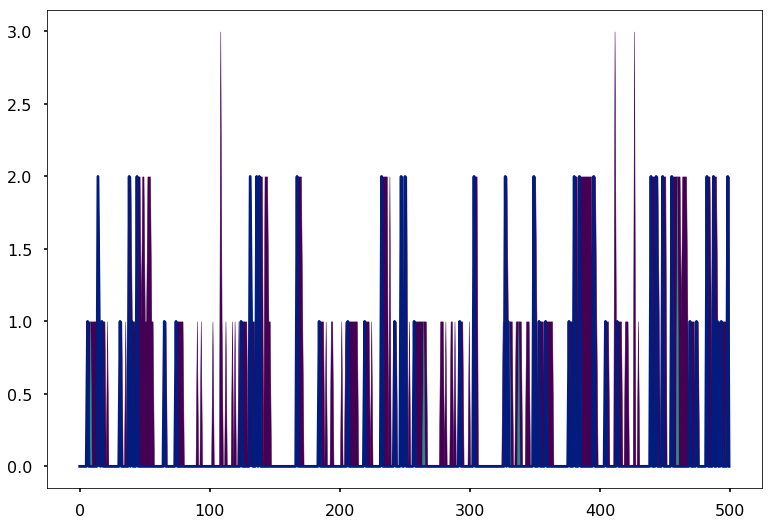

In [17]:
state_comparison_fig, state_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(state_comparison_ax, pd.DataFrame(cluster_identity_draws.T), percentiles)
#state_comparison_ax.plot(cluster_series, c='red')

In [18]:
pd.DataFrame(np.nanmean(beta_draws, axis=0)).dropna()

/home/sangrey/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


0         1
0 -0.002162  0.904597
1 -0.940001  0.012763
2  0.997643 -0.046212
3 -0.101896  0.096355
4 -0.107131  0.056841
5 -0.060069  0.016594
6 -0.390171 -0.028993

In [19]:
pd.DataFrame(precision_draws**(-.5)).mean().dropna()

0    0.101209
1    0.108019
2    0.099901
3    0.100370
4    0.100298
5    0.100794
6    0.109754
dtype: float64

In [20]:
cdpm.compute_probabilities(pd.DataFrame(stick_draws).mean().dropna())

array([  8.84455098e-01,   6.35443430e-02,   4.92239206e-02,
         1.96811623e-03,   4.86879423e-04,   1.87280529e-04,
         9.73486608e-05])

In [21]:
np.cumsum(cdpm.compute_probabilities(pd.DataFrame(stick_draws).mean().dropna()))

array([ 0.8844551 ,  0.94799944,  0.99722336,  0.99919148,  0.99967836,
        0.99986564,  0.99996299])

In [22]:
np.nanmean(trans_mat_draws, axis=0)[:3,:3]

/home/sangrey/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


array([[ 0.88123184,  0.06582127,  0.05402158],
       [ 0.92321762,  0.0588928 ,  0.01665046],
       [ 0.86478805,  0.0874845 ,  0.04641777]])

## Get the dynamics of alpha's

In [23]:
alpha_est_mat = np.empty((time_dim-1, num_draws))

In [24]:
for draw in tqdm(range(num_draws)):
    for t_idx in range(1, time_dim):
        cluster_identity = cluster_identity_draws[draw,t_idx-1].astype(int)
        cl_idx = np.argmax(np.random.multinomial(n=1,pvals=trans_mat_draws[draw][cluster_identity,:]).astype(
            np.bool))
        alpha_f = (np.dot(with_mean_regressor[t_idx-1],beta_draws[draw,cl_idx])
                   + precision_draws[draw, cl_idx]**(-.5) * np.random.normal(0,1, size=1))
        alpha_est_mat[t_idx-1, draw] = np.asscalar(alpha_f)

100%|██████████| 20000/20000 [02:47<00:00, 119.54it/s]


In [25]:
percentiles = [.1, 1,5, 25, 50, 75, 95, 99, 99.9]

In [26]:
plt.rcParams['image.cmap'] = 'PuBuGn'

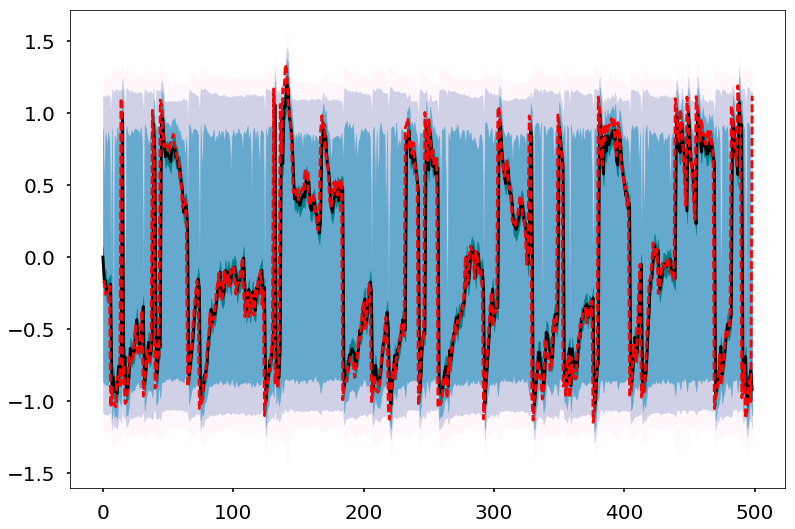

In [27]:
alpha_comparison_fig, alpha_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(alpha_comparison_ax, pd.DataFrame(alpha_est_mat[:500]), percentiles, color='black')
alpha_comparison_ax.plot(alpha_series[1:500], c='red', linestyle='--')
for label in alpha_comparison_ax.get_xticklabels():
    label.set_fontsize(20)
for label in alpha_comparison_ax.get_yticklabels():
    label.set_fontsize(20)
alpha_comparison_filename = '/home/sangrey/Repositories/DirichletProcessMixture/doc/figures/alpha_series_est2.tmp.png'
alpha_comparison_fig.savefig(alpha_comparison_filename, bbox_inches='tight', pad_inches=0)

In [28]:
pit1 = mcmc.probability_integral_transform(alpha_est_mat, alpha_series[1:])

/home/sangrey/anaconda3/lib/python3.5/site-packages/bayesiankalman/mcmc.py:626: RuntimeWarning: invalid value encountered in less
  return_vals = np.asarray([np.mean(np.less(data, point), axis=0) for point in eval_points])


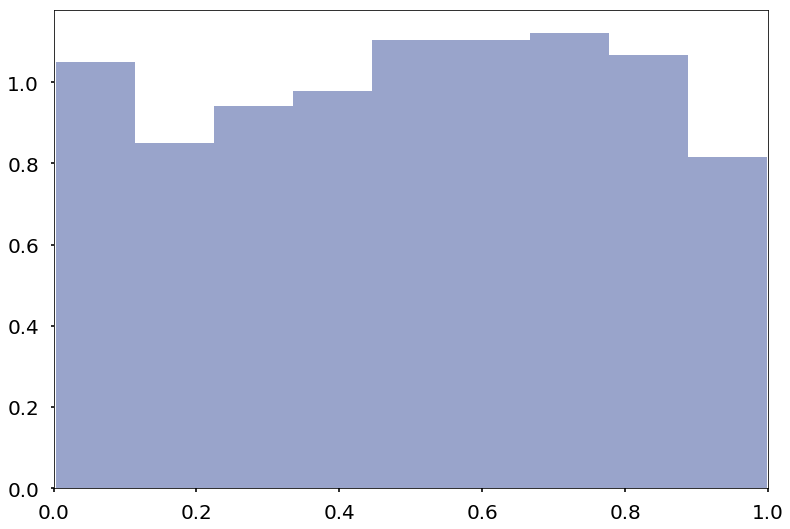

In [29]:
pit_fig = plt.figure()
pit_ax = pit_fig.add_subplot(111)
sns.distplot(pit1, kde=False, norm_hist=True, ax=pit_ax)
pit_ax.set_xlim([0,1])
for label in pit_ax.get_xticklabels():
    label.set_fontsize(20)
for label in pit_ax.get_yticklabels():
    label.set_fontsize(20)
pit_filename = '/home/sangrey/Repositories/DirichletProcessMixture/doc/figures/alpha_series_pit2.tmp.png'
pit_fig.savefig(pit_filename,bbox_inches='tight', pad_inches=0)

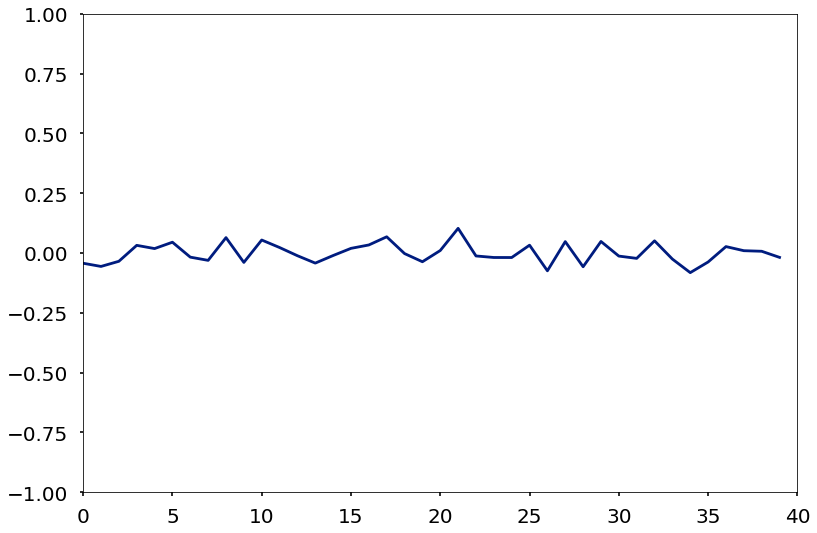

In [30]:
acf_filename = '/home/sangrey/Repositories/DirichletProcessMixture/doc/figures/alpha_series_acorr2.tmp.png'
acf_fig = plt.figure()
acf_ax = acf_fig.add_subplot(111)
acf_ax.plot(acf(pit1)[1:])
acf_ax.set_ylim([-1,1])
for label in acf_ax.get_xticklabels():
    label.set_fontsize(20)
for label in acf_ax.get_yticklabels():
    label.set_fontsize(20)
acf_ax.set_xlim([0, 40])
acf_fig.savefig(acf_filename, bbox_inches='tight', pad_inches=0)